In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

## Splitting Dataset

Splitting the dataset to `train` and `test`, which equal distribution of gender in each set. Further EDA and training will be constructed on the `train` before testing.

In [ ]:
df = pd.read_csv("./dataset/participants.tsv", sep="\t")

In [30]:
def stratified_split(group):
    males = group[group["Gender"] == "M"].sample(frac=1, random_state=42)  # Shuffle
    females = group[group["Gender"] == "F"].sample(frac=1, random_state=42)  # Shuffle

    num_males_train = int(len(males) * 0.8)
    num_females_train = int(len(females) * 0.8)

    males["Set"] = ["Train"] * num_males_train + ["Test"] * (len(males) - num_males_train)
    females["Set"] = ["Train"] * num_females_train + ["Test"] * (len(females) - num_females_train)

    return pd.concat([males, females])

In [ ]:
df_A = df[df["Group"] == "A"]
df_C = df[df["Group"] == "C"]
df_F = df[df["Group"] == "F"]

df_A = stratified_split(df_A)
df_C = stratified_split(df_C)
df_F = stratified_split(df_F)

df = pd.concat([df_A, df_C, df_F], ignore_index=True)

In [34]:
df.to_csv("./dataset/participants.tsv", sep="\t")

## Power Spectrum

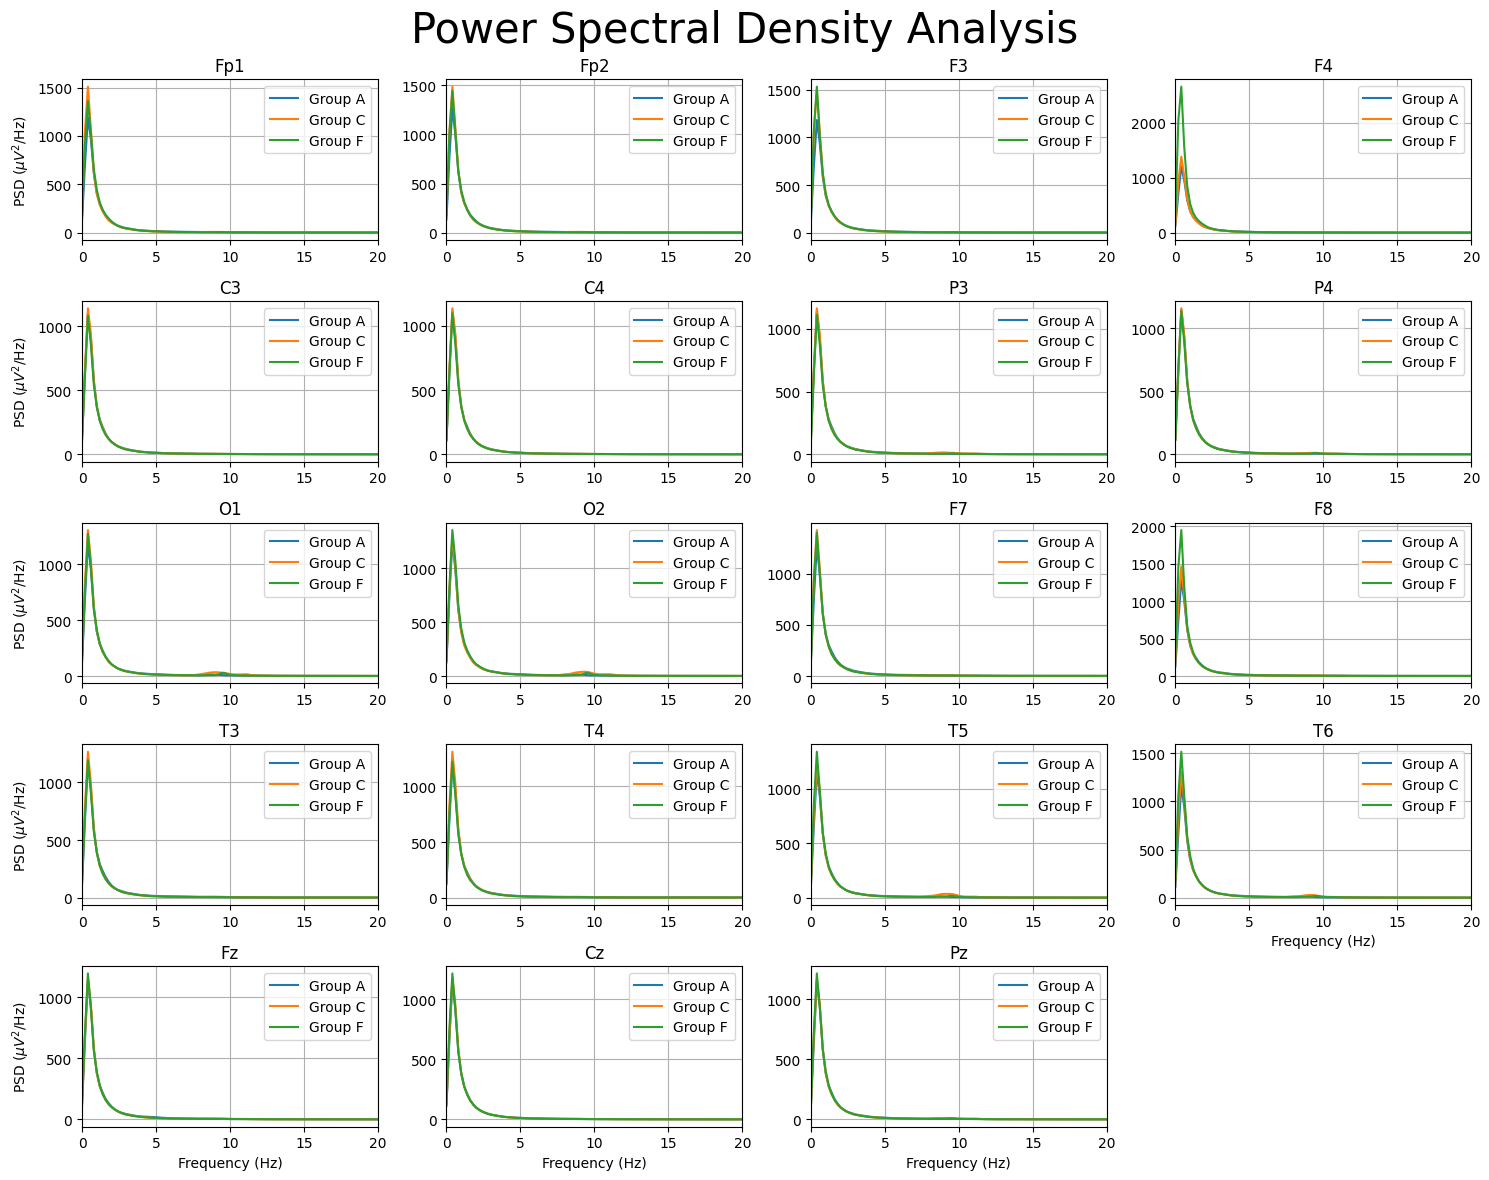

In [53]:
eeg_columns = pd.read_csv("./dataset/derivative_5min/sub-001.csv").columns
psd_results = {"A": [], "C": [], "F": []}

for _, row in df.iterrows():
    participant_id = row["participant_id"]
    group = row["Group"]
    set_type = row["Set"]

    if set_type == "Train":
        file_path = os.path.join("./dataset/derivative_5min", f"{participant_id}.csv")
        
        # Load the participant's EEG data
        if os.path.exists(file_path):
            participant_data = pd.read_csv(file_path)
            
            # Extract EEG signal columns
            eeg_data = participant_data[eeg_columns].values

            # Compute Welch's PSD
            freqs, psd = welch(eeg_data, fs=500, nperseg=2500, axis=0)

            psd_results[group].append(psd)

fig, axes = plt.subplots(5, 4, figsize=(15, 12))
axes = axes.flatten()
fig.suptitle("Power Spectral Density Analysis", fontsize=30)

for i, channel in enumerate(eeg_columns):
    ax = axes[i]
    
    for group, psd_list in psd_results.items():
        if psd_list:
            avg_psd = np.mean(np.array(psd_list), axis=0)  # Average
            ax.plot(freqs, avg_psd[:, i], label=f"Group {group}")
    
    ax.set_title(f"{channel}")
    ax.set_xlim(0, 20)  # Restrict frequency range to 0-20 Hz as suggested by paper
    ax.grid(True)
    
    # Only show y-label on the leftmost column
    if i % 4 == 0:
        ax.set_ylabel(r"PSD ($\mu V^2$/Hz)")

    # Only show x-label on the bottom row
    if i >= len(axes) - 4 or i == 15:
        ax.set_xlabel("Frequency (Hz)")

    ax.legend(loc="upper right")

# Hide empty subplot
axes[-1].axis("off")

plt.tight_layout()
plt.show()